# Netflix Content Recommendation System
This notebook implements a hybrid recommendation system for Netflix movies and TV shows using:
1. Content-based filtering with TF-IDF vectorization and cosine similarity
2. Collaborative filtering based on user preferences
3. Node representation learning for enhanced content understanding

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.sparse.linalg import svds
import networkx as nx
from node2vec import Node2Vec

## 1. Data Loading and Preprocessing

In [11]:
# Load and preprocess the data
df = pd.read_csv('netflix_titles.csv')
df.head()


show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [ ]:
# Create a combined features column for content-based filtering
def create_soup(x):
    features = []
    if isinstance(x['description'], str):
        features.append(x['description'])
    if isinstance(x['cast'], str):
        features.append(x['cast'])
    if isinstance(x['director'], str):
        features.append(x['director'])
    if isinstance(x['listed_in'], str):
        features.append(x['listed_in'])
    if isinstance(x['title'], str):
        features.append(x['title'])
    return ' '.join(features)

df['combined_features'] = df.apply(create_soup, axis=1)

## 2. Content-Based Filtering

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## 3. Collaborative Filtering

In [14]:
def create_user_item_matrix(df, n_users=1000):
    # Simulate user ratings (for demonstration)
    np.random.seed(42)
    n_items = len(df)
    user_item_matrix = np.random.randint(0, 6, size=(n_users, n_items)) * (np.random.random((n_users, n_items)) > 0.8)
    return user_item_matrix

def matrix_factorization(ratings, n_factors=50):
    # Normalize the ratings
    user_ratings_mean = np.mean(ratings, axis=1)
    ratings_norm = ratings - user_ratings_mean.reshape(-1, 1)
    
    # Singular Value Decomposition
    U, sigma, Vt = svds(ratings_norm, k=n_factors)
    sigma = np.diag(sigma)
    
    # Predict ratings
    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return predicted_ratings

user_item_matrix = create_user_item_matrix(df)

predicted_ratings = matrix_factorization(user_item_matrix)

## 4. Node Representation Learning

In [15]:
def create_content_graph(df):
    G = nx.Graph()
    
    # Pre-process genres to reduce iterations
    genre_dict = {}
    for idx, row in df.iterrows():
        if isinstance(row['listed_in'], str):
            genres = [g.strip() for g in row['listed_in'].split(',')]
            genre_dict[idx] = genres
            
            # Add unique genres as nodes
            for genre in genres:
                if not G.has_node(genre):
                    G.add_node(genre, type='genre')
    
    # Batch add content nodes
    content_nodes = [(idx, {'title': row['title'], 'type': 'content'}) 
                    for idx, row in df.iterrows()]
    G.add_nodes_from(content_nodes)
    
    # Batch add edges
    edges = [(idx, genre, 1.0) 
            for idx, genres in genre_dict.items() 
            for genre in genres]
    G.add_weighted_edges_from(edges)
    
    return G

def learn_node_embeddings(G, cache_file='node_embeddings.pkl'):
    import os
    from joblib import dump, load
    
    # Try to load cached embeddings
    if os.path.exists(cache_file):
        try:
            return load(cache_file)
        except:
            pass
    
    # Initialize Node2Vec with optimized parameters
    node2vec = Node2Vec(
        G,
        dimensions=32,      # Reduced from 64
        walk_length=10,     # Reduced from 30
        num_walks=50,       # Reduced from 200
        workers=4,          # Parallel processing
        p=1,               # Return parameter
        q=1,               # In-out parameter
        quiet=True         # Reduce output
    )
    
    # Train the model with optimized parameters
    model = node2vec.fit(
        window=5,          # Reduced from 10
        min_count=1,
        batch_words=4000   # Increased batch size
    )
    
    # Cache the embeddings
    dump(model, cache_file)
    
    return model

# Create content graph and learn embeddings with progress tracking
from tqdm import tqdm

print("Creating content graph...")
content_graph = create_content_graph(df)

print("Learning node embeddings...")
with tqdm(total=1, desc="Node2Vec training") as pbar:
    node_embeddings = learn_node_embeddings(content_graph)
    pbar.update(1)

Creating content graph...
Learning node embeddings...


Node2Vec training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


## 5. Hybrid Recommendation Function

In [16]:
def get_hybrid_recommendations(query, cosine_sim=cosine_sim, df=df, n_recommendations=10):
    """
    Get hybrid recommendations based on content similarity and node embeddings.
    
    Args:
        query (str): Title or description to base recommendations on
        cosine_sim (np.ndarray): Pre-computed cosine similarity matrix
        df (pd.DataFrame): DataFrame containing Netflix content
        n_recommendations (int): Number of recommendations to return
    
    Returns:
        pd.DataFrame: DataFrame containing recommended items and their scores
    """
    try:
        # First try to find the title in the database
        idx = df[df['title'].str.lower() == query.lower()].index
        
        # If title not found, treat input as description
        if len(idx) == 0:
            if not isinstance(query, str):
                raise ValueError("Query must be a string")
            temp_tfidf = tfidf.transform([query])
            content_scores = cosine_similarity(temp_tfidf, tfidf_matrix).flatten()
            is_description = True
        else:
            idx = idx[0]
            content_scores = cosine_sim[idx]
            is_description = False
        
        # Initialize weights for different components
        weights = {
            'content': 0.7,
            'node_embeddings': 0.3
        }
        
        # Normalize content scores
        content_scores = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min())
        
        # Initialize final scores with content-based scores
        final_scores = weights['content'] * content_scores
        
        # Add node embedding similarity if available
        if not is_description and 'node_embeddings' in globals():
            try:
                node_scores = np.array([
                    node_embeddings.wv.similarity(str(idx), str(i))
                    if str(i) in node_embeddings.wv and str(idx) in node_embeddings.wv
                    else 0
                    for i in range(len(df))
                ])
                node_scores = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
                final_scores += weights['node_embeddings'] * node_scores
            except (AttributeError, KeyError) as e:
                print(f"Warning: Node embeddings error - {str(e)}. Using content-based only.")
                weights['content'] = 1.0
                weights['node_embeddings'] = 0
        else:
            weights['content'] = 1.0
            weights['node_embeddings'] = 0
        
        # Get top N recommendations
        sim_scores_with_index = list(enumerate(final_scores))
        sim_scores_with_index = sorted(sim_scores_with_index, key=lambda x: x[1], reverse=True)
        sim_scores_with_index = sim_scores_with_index[1:n_recommendations+1] if not is_description else sim_scores_with_index[:n_recommendations]
        
        # Create recommendations DataFrame
        recommendations = []
        for i, score in sim_scores_with_index:
            recommendations.append({
                'title': df['title'].iloc[i],
                'type': df['type'].iloc[i],
                'similarity_score': score,
                'description': df['description'].iloc[i],
                'genres': df['listed_in'].iloc[i],
                'score_components': {
                    'content': content_scores[i] * weights['content'],
                    'node_embeddings': node_scores[i] * weights['node_embeddings'] if 'node_scores' in locals() else 0
                }
            })
        
        recommendations_df = pd.DataFrame(recommendations)
        
        # Create visualization
        fig = go.Figure(data=[
            go.Bar(
                x=recommendations_df['title'],
                y=recommendations_df['similarity_score'],
                marker_color=recommendations_df['similarity_score'],
                text=recommendations_df['similarity_score'].round(3),
                textposition='auto',
                hovertemplate=(
                    "<b>%{x}</b><br>" +
                    "Total Score: %{y:.3f}<br>" +
                    "Type: %{customdata[0]}<br>" +
                    "Genres: %{customdata[1]}<br>" +
                    "<extra></extra>"
                ),
                customdata=recommendations_df[['type', 'genres']].values
            )
        ])
        
        fig.update_layout(
            title={
                'text': f'Top {n_recommendations} Recommendations' + (f' for "{query}"' if not is_description else ''),
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            xaxis_title='Title',
            yaxis_title='Similarity Score',
            xaxis_tickangle=-45,
            height=600,
            margin=dict(b=150),
            showlegend=False
        )
        
        fig.show()
        return recommendations_df
        
    except Exception as e:
        print(f"Error in recommendation system: {str(e)}")
        return pd.DataFrame()

## Example Usage

In [17]:
# Get recommendations by description
recommendations = get_hybrid_recommendations("A thrilling supernatural story with mystery and horror elements")
recommendations

title     type  \
0                               Five Elements Ninjas    Movie   
1      Earth's Natural Wonders: Life at the Extremes  TV Show   
2                                   Forces of Nature  TV Show   
3                                         Big Timber  TV Show   
4                                    Stranger Things  TV Show   
5          SHOT! The Psycho-Spiritual Mantra of Rock    Movie   
6                          Malibu Rescue: The Series  TV Show   
7                                             Kanika    Movie   
8                                       Family Blood    Movie   
9  An American Tail: The Mystery of the Night Mon...    Movie   

   similarity_score                                        description  \
0          0.700000  When five ninjas whose fighting styles are bas...   
1          0.542616  From the Arctic to the Outback, humans battle ...   
2          0.515814  This dynamic series spans the globe to explain...   
3          0.510249  A no-nonsense logger and his loyal crew battle...   
4          0.495280  When a young boy vanishes, a small town uncove...   
5          0.474878  Aptly named iconic rock photographer Mick Rock...   
6          0.470982  On the heels of Junior Rescue training, Team F...   
7          0.452191  A doctor and his colleagues who use sex-determ...   
8          0.445207  A former addict moves to a new city with her c...   
9          0.439914  When a monster goes on a mouse-napping spree i...   

                                              genres  \
0           Action & Adventure, International Movies   
1  British TV Shows, Docuseries, Science & Nature TV   
2  British TV Shows, Docuseries, Science & Nature TV   
3                 International TV Shows, Reality TV   
4       TV Horror, TV Mysteries, TV Sci-Fi & Fantasy   
5                    Documentaries, Music & Musicals   
6       Kids' TV, TV Action & Adventure, TV Comedies   
7     Horror Movies, International Movies, Thrillers   
8                                      Horror Movies   
9                           Children & Family Movies   

                                    score_components  
0             {'content': 1.0, 'node_embeddings': 0}  
1  {'content': 0.7751661835752652, 'node_embeddin...  
2  {'content': 0.7368765426984699, 'node_embeddin...  
3  {'content': 0.7289268059265909, 'node_embeddin...  
4  {'content': 0.7075426826101006, 'node_embeddin...  
5  {'content': 0.6783969969392141, 'node_embeddin...  
6  {'content': 0.6728318789515935, 'node_embeddin...  
7  {'content': 0.6459868562691757, 'node_embeddin...  
8  {'content': 0.6360106514614375, 'node_embeddin...  
9  {'content': 0.6284485470424953, 'node_embeddin...

C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_39040\185366988.py:58: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



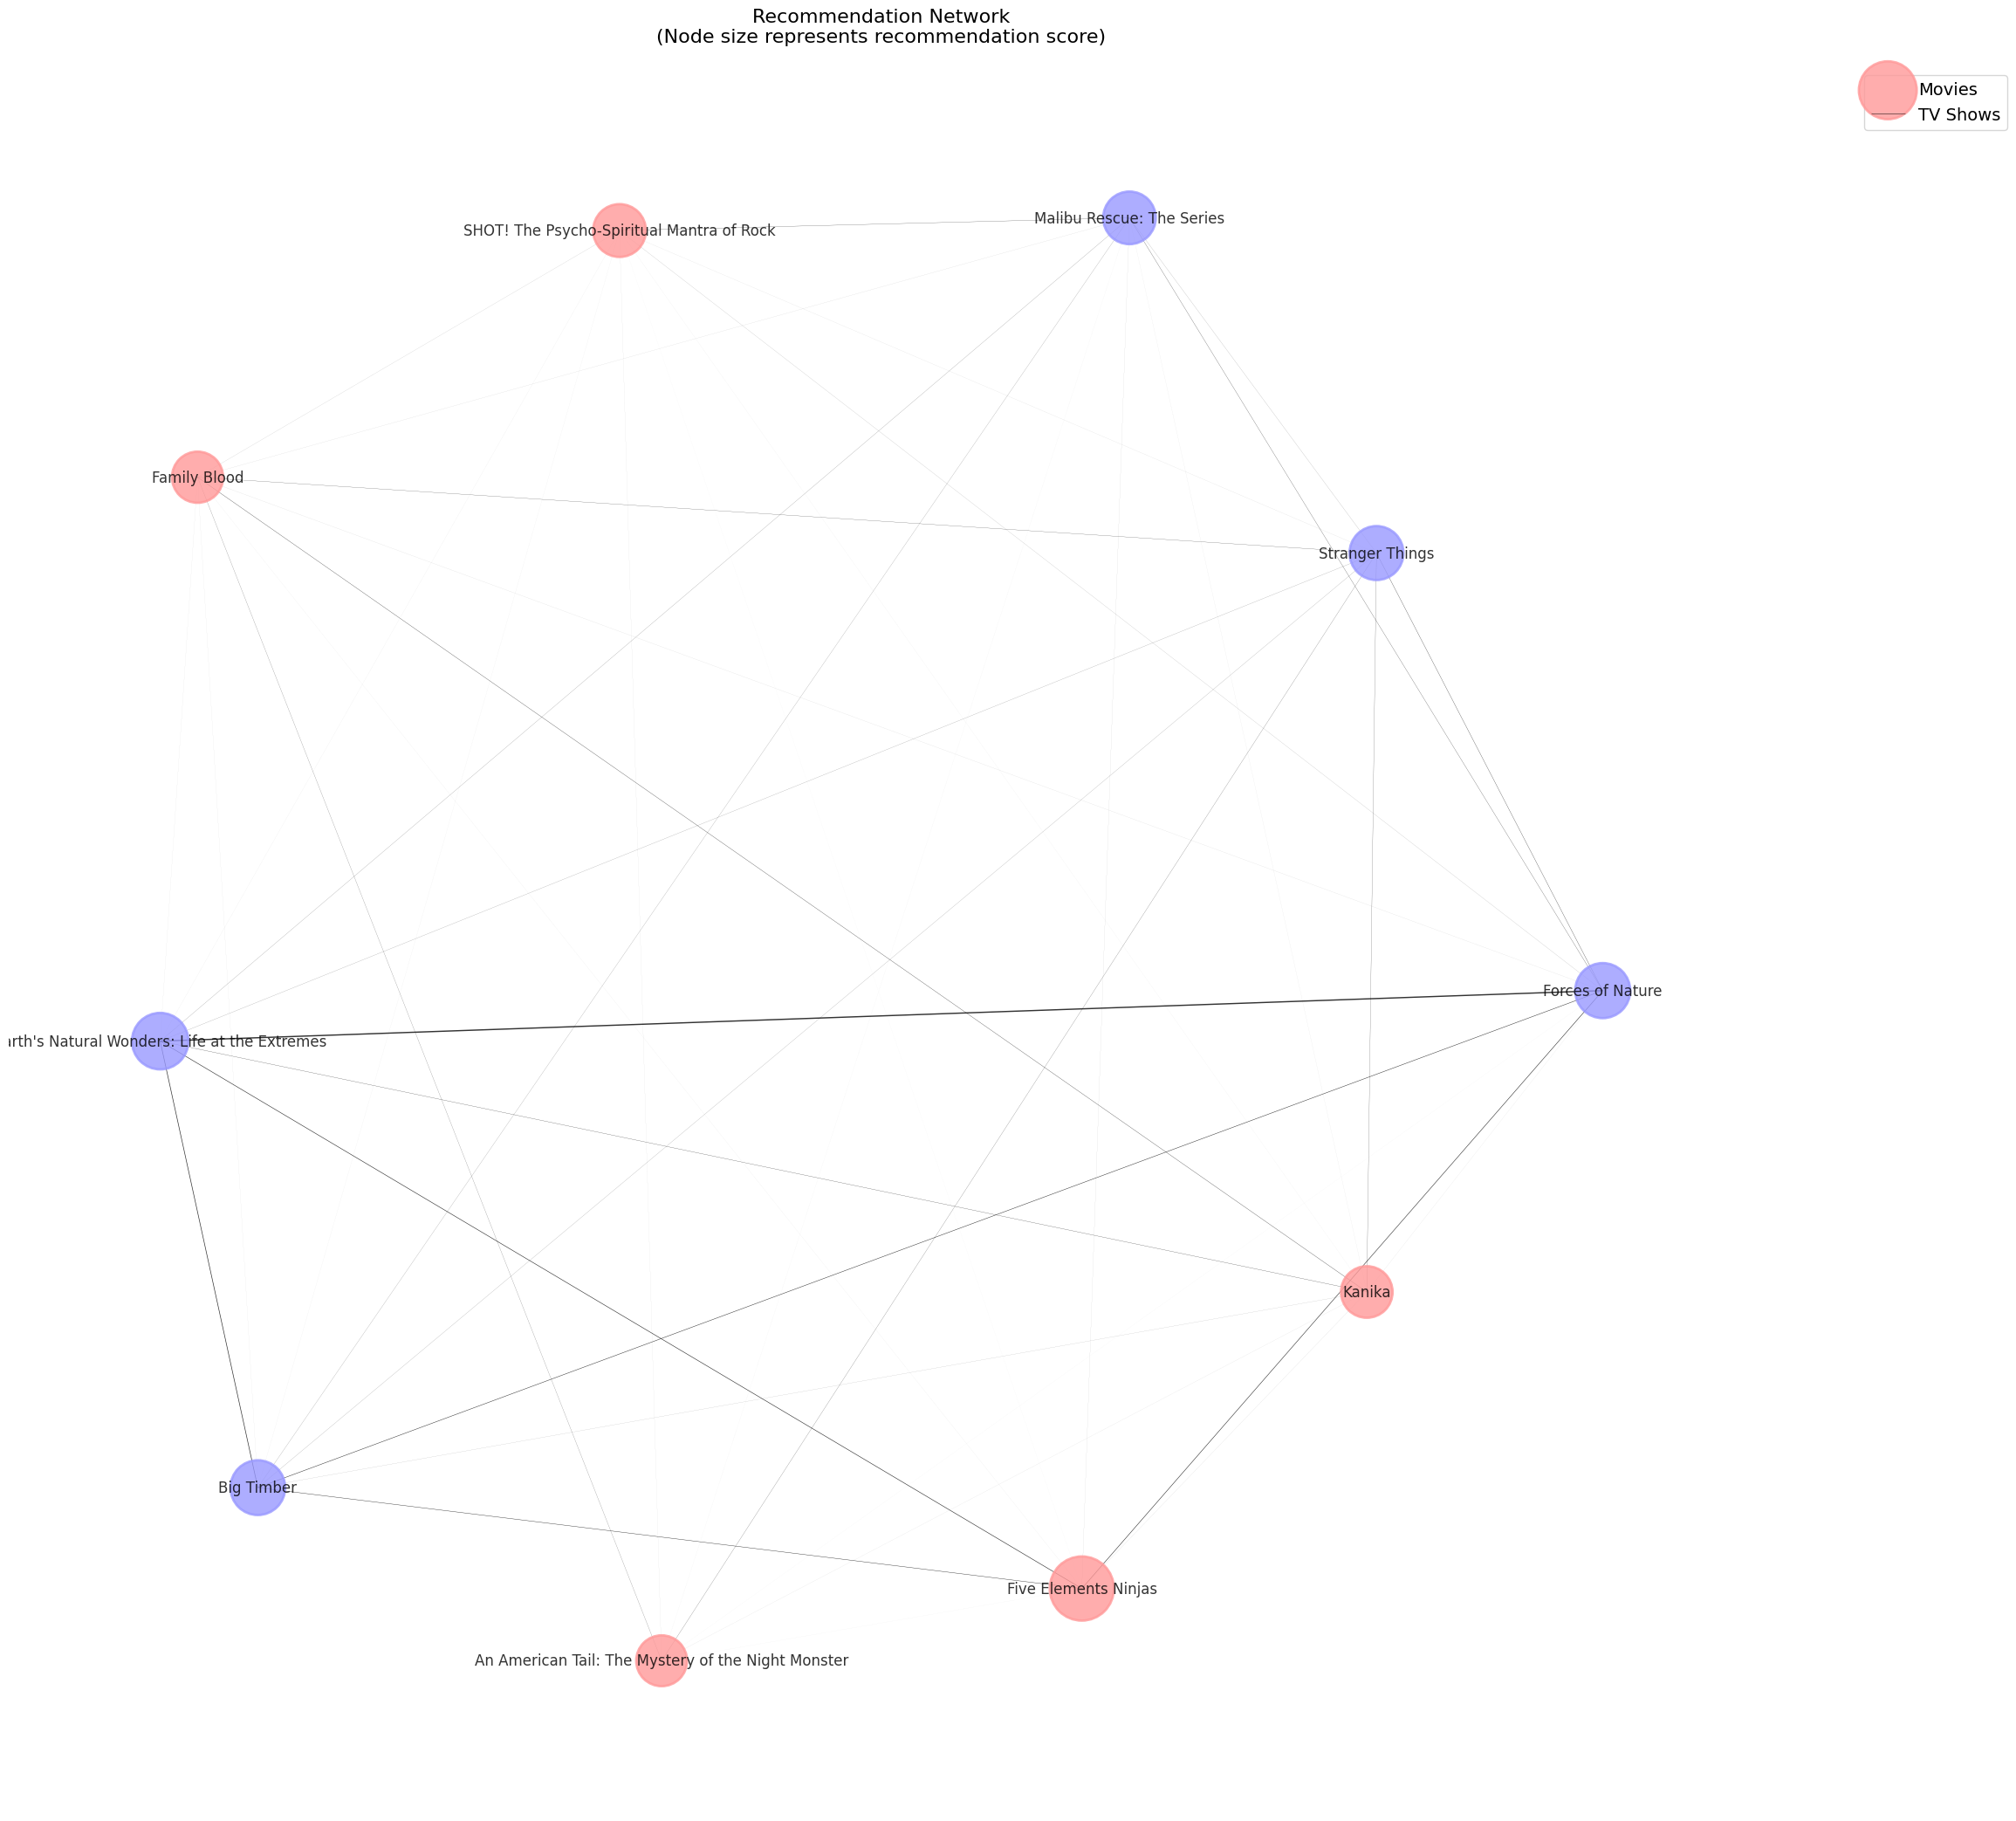


Recommendation Network Analysis:
Number of recommended items: 10
Number of connections: 45
Network density: 1.000


In [18]:
def visualize_recommendations_network(recommendations, df, tfidf_matrix):
    """
    Create a network visualization for recommended content
    """
    # Create a graph
    G = nx.Graph()
    
    # Get indices of recommended items
    rec_indices = [df[df['title'] == title].index[0] for title in recommendations['title']]
    
    # Add nodes for recommended items
    for _, row in recommendations.iterrows():
        G.add_node(row['title'], 
                  type=row['type'],
                  score=row['similarity_score'])
    
    # Add edges between recommendations based on TF-IDF similarity
    for idx1, title1 in enumerate(recommendations['title']):
        idx_in_df = df[df['title'] == title1].index[0]
        similarities = cosine_similarity(tfidf_matrix[idx_in_df:idx_in_df+1], 
                                      tfidf_matrix[rec_indices])[0]
        
        for idx2, title2 in enumerate(recommendations['title']):
            if title1 != title2:
                G.add_edge(title1, title2, weight=similarities[idx2])

    # Visualization with larger figure size
    plt.figure(figsize=(20, 20))
    
    # Node colors based on type with increased opacity
    node_colors = ['#FF9999' if G.nodes[node]['type'] == 'Movie' else '#9999FF' 
                  for node in G.nodes()]
    
    # Increased node sizes (multiplied by 4000 instead of 2000)
    node_sizes = [G.nodes[node]['score'] * 4000 for node in G.nodes()]
    
    # Create layout with more spacing
    pos = nx.spring_layout(G, k=2.0)
    
    # Draw network with thicker edges and larger font
    nx.draw(G, pos,
           node_color=node_colors,
           node_size=node_sizes,
           with_labels=True,
           font_size=12,  # Increased font size
           width=[G[u][v]['weight'] * 4 for u,v in G.edges()],  # Thicker edges
           alpha=0.8,  # Increased opacity
           linewidths=2)  # Added node border width
    
    # Add legend with larger font
    plt.legend(['Movies', 'TV Shows'],
              loc='upper right',
              bbox_to_anchor=(1.15, 1.0),
              fontsize=14)  # Increased legend font size
    
    plt.title('Recommendation Network\n(Node size represents recommendation score)',
              pad=20, fontsize=16)  # Increased title font size
    plt.tight_layout()
    
    return G

# Create visualization for the recommendations
recommendations_network = visualize_recommendations_network(recommendations, df, tfidf_matrix)
plt.show()

# Print network statistics
print("\nRecommendation Network Analysis:")
print(f"Number of recommended items: {recommendations_network.number_of_nodes()}")
print(f"Number of connections: {recommendations_network.number_of_edges()}")
print(f"Network density: {nx.density(recommendations_network):.3f}")